# Dataset 0: images containing text

Very ideal experiment to see the lower bound performance


Version - 0:
- Text content: SQUAD v1.1
- Uniform size: width, height, margins, line space across the dataset
- Uniform style: white background, black text, font size, font style
- Tasks 0: word search, put a bounding box around a word
    - Exact match
    - No special characters in content
    - Case insensitive
    - Words are equally likely
    - Word actually exists!


Algorithm - 0:
- Create words dictionary from SQUAD
- Create an index word -> paragraphs that have this word
- Uniformly select a word, uniformly select associated paragraph
- Uniformly select an occurance in paragraph and annotate a bounding box


In [1]:
DATA_DIR = "./data"

In [3]:
%matplotlib inline

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from matplotlib.pyplot import imshow
from glob import glob
from collections import defaultdict
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import textwrap
import json
import re
import os

# Document to Image

In [6]:
def create_image(
    sentence, 
    font_file, 
    font_size=12, 
    bg_color="black", 
    fg_color="white", 
    img_width=None, 
    img_height=None
):
    font = ImageFont.truetype(font_file, font_size)
    w, h = font.getsize(sentence)
    if img_width is not None:
        w = img_width
    if img_height is not None:
        h = img_height
    img = Image.new("1", (w, h), color=bg_color)
    draw = ImageDraw.Draw(img)
    draw.text((0,0), sentence, font=font, fill=fg_color)
    return img


def stack_images(images, line_space=0, bg_color="black"):
    w = max(i.width for i in images)
    h = sum(i.height for i in images) + (line_space * (len(images)-1))
    stacked = Image.new("1", (w, h), color=bg_color)
    start = 0
    for i, img in enumerate(images):
        stacked.paste(img, (0, start))
        start += img.height + line_space
    return stacked


def append_images(images, word_space=0, bg_color="black"):
    w = sum(i.width  for i in images) + ((len(images) - 1) * word_space)
    h = max(i.height for i in images)
    appended = Image.new("1", (w, h), color=bg_color)
    start = 0
    for i, img in enumerate(images):
        appended.paste(img, (start, 0))
        start += img.width + word_space
    return appended


def add_margin(image, top=0, right=0, bottom=0, left=0, bg_color="black"):
    w = image.width + right + left
    h = image.height + top + bottom
    enlarged = Image.new(image.mode, (w, h), bg_color)
    enlarged.paste(image, (left, top))
    return enlarged


def parsed_text(s):
    filtered = [ch if ch.isalnum() else " " for ch in s]
    s = "".join(filtered)
    s = " ".join(s.split())
    return s.lower()


def tokenizer(s):
    # preserve whitespace
    return re.split(r'(\s+)', s)


def doc_to_image(
    doc, 
    font_file, 
    font_size=12,
    bg_color="black",
    fg_color="white",
    margin=0,
    line_space=0,
    word_space=0,
):
    annotations = defaultdict(list) # token -> [(x, y, w, h), ... ]
    doc = parsed_text(doc)
    images = []
    cursor_y = margin
    for sentence in textwrap.wrap(doc):
        cursor_x = margin
        sentence_images = []
        for token in tokenizer(sentence):
            token_img = create_image(token, font_file, font_size, bg_color, fg_color)
            annotations[token].append((cursor_x, cursor_y, token_img.width, token_img.height))
            sentence_images.append(token_img)
            cursor_x += token_img.width + word_space
        appended = append_images(sentence_images, word_space, bg_color)
        images.append(appended)
        cursor_y += appended.height + line_space
    x = stack_images(images, line_space, bg_color)
    x = add_margin(x, margin, margin, margin, margin, bg_color)
    
    # pop whitespaces
    for k in list(annotations.keys()):
        if k.strip() == "":
            annotations.pop(k)
    
    return x, annotations

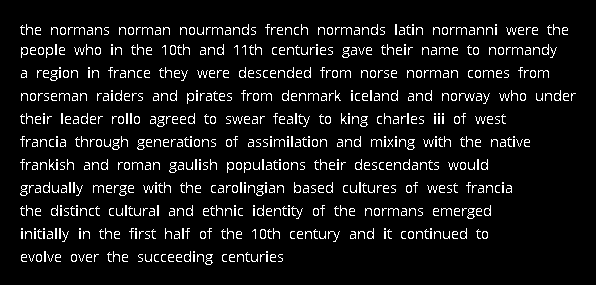

In [7]:
font_file = DATA_DIR + "/fonts/apache/opensans/OpenSans-Regular.ttf"
doc = """The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries."""
img, ann = doc_to_image(doc, font_file, font_size=14, margin=20, line_space=5, word_space=2)
img

In [8]:
def show_bounding_box(img, annotation, spread=0, color="red"):
    x, y, w, h = annotation
    x -= spread
    y -= spread
    w += 2 * spread
    h += 2 * spread
    new = img.copy().convert("RGB")
    draw = ImageDraw.Draw(new)
    draw.rectangle((x, y, x + w, y + h), outline=color)
    return new

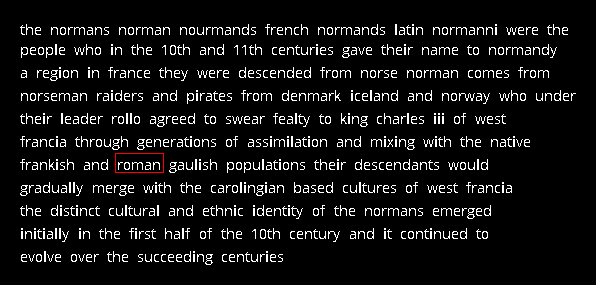

In [9]:
show_bounding_box(img, ann["roman"][0], spread=2)

# Create Dataset

In [10]:
def squad_doc_reader(fname):
    data = [] # {id, doc}
    index = set()
    with open(fname) as f:
        file_data = json.load(f)
    for idx, item in enumerate(file_data["data"]):
        title = item["title"]
        for idy, para in enumerate(item["paragraphs"]):
            context = para["context"]
            key = f"{title}__{idx}__{idy}"
            if key in index:
                raise Exception(f"{key} already exists")
            else:
                data.append({"id": key, "doc": context})
                index.add(key)
    return data


train_docs = squad_doc_reader(DATA_DIR + "/squad/train-v2.0.json")
dev_docs = squad_doc_reader(DATA_DIR + "/squad/dev-v2.0.json")
train_docs[0]

{'id': 'Beyoncé__0__0',
 'doc': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'}

In [18]:
# save images and annotations
def worker(item, **kw):
    img, ann = doc_to_image(
        doc=item["doc"], 
        font_file=kw["font_file"],
        font_size=kw["font_size"],
        bg_color=kw["bg_color"],
        fg_color=kw["fg_color"],
        margin=kw["margin"],
        line_space=kw["line_space"],
        word_space=kw["word_space"]
    )
    filename = os.path.join(kw["path"], item["id"])
    img.save(filename + ".png")
    with open(filename + ".json", "w", encoding="utf8") as fp:
        json.dump(ann, fp, indent=2, ensure_ascii=False)
    return filename

        
def create_image_docs(docs, **worker_kw):
    os.makedirs(worker_kw["path"], exist_ok=True)
    with ProcessPoolExecutor(max_workers=10) as executor:
        futures_to_id = {executor.submit(worker, item, **worker_kw): item["id"] for item in docs}
        for future in tqdm(as_completed(futures_to_id), total=len(futures_to_id)):
            doc_id = futures_to_id[future]
            output = future.result()

In [19]:
create_image_docs(
    train_docs,
    path=DATA_DIR + "/v0/train/",
    font_file=DATA_DIR + "/fonts/apache/opensans/OpenSans-Regular.ttf",
    font_size=14,
    line_space=5,
    word_space=2,
    margin=20,
    bg_color="black",
    fg_color="white",
)

In [20]:
create_image_docs(
    dev_docs,
    path=DATA_DIR + "/v0/dev/",
    font_file=DATA_DIR + "/fonts/apache/opensans/OpenSans-Regular.ttf",
    font_size=14,
    line_space=5,
    word_space=2,
    margin=20,
    bg_color="black",
    fg_color="white",
)

# Image Dim Equalize 

In [55]:
def expand_to_image(img, new_h, new_w, bg_color):
    left = (new_w - img.width) // 2
    right = (new_w - img.width) - left
    top = (new_h - img.height) // 2
    bottom = (new_h - img.height) - top
    img = add_margin(img, top, right, bottom, left, bg_color)
    return img, left, top


def resize_dataset(path, bg_color):
    # get max sizes
    max_h = -float("inf")
    max_w = -float("inf")
    for filename in glob(path + "/*.png"):
        im = Image.open(filename)
        max_h = max(max_h, img.height)
        max_w = max(max_w, img.width)
    
    processed = 0
    for filename in tqdm(glob(path + "/*.png")):
        im = Image.open(filename)
        if im.height != max_h or im.width != max_w:
            im, offset_x, offset_y = expand_to_image(im, max_h, max_w, bg_color)
            # update image dim
            im.save(filename)
            # offset bounding box postions
            with open(filename.replace(".png", ".json"), encoding="utf8") as fp:
                features = json.load(fp)
            for key, bb_list in features.items():
                for bb in bb_list:
                    bb[0] += offset_x
                    bb[1] += offset_y
            with open(filename.replace(".png", ".json"), "w", encoding="utf8") as fp:
                json.dump(features, fp, indent=2, ensure_ascii=False)

            processed += 1
    
    return processed

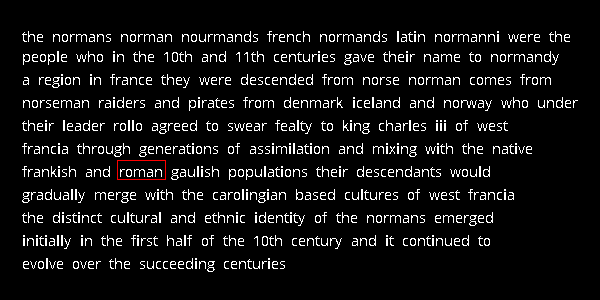

In [36]:
img, ann = doc_to_image(doc, font_file, font_size=14, margin=20, line_space=5, word_space=2)
img, offset_x, offset_y = expand_to_image(img, 300, 600, "black")

cursor_x, cursor_y, w, h = ann["roman"][0]
cursor_x += offset_x
cursor_y += offset_y

show_bounding_box(img, (cursor_x, cursor_y, w, h), spread=2)

In [61]:
resize_dataset(DATA_DIR + "/v0/train", "black")

19035

In [57]:
resize_dataset(DATA_DIR + "/v0/dev", "black")

1204

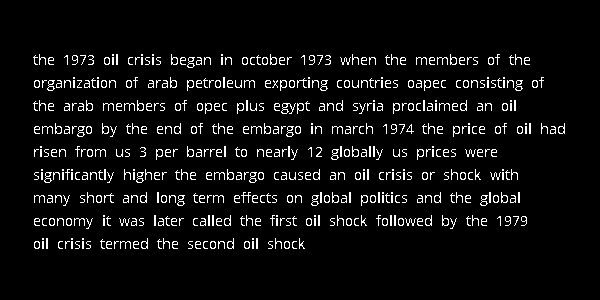

In [58]:
img = Image.open(DATA_DIR+"/v0/dev/1973_oil_crisis__8__0.png")
img

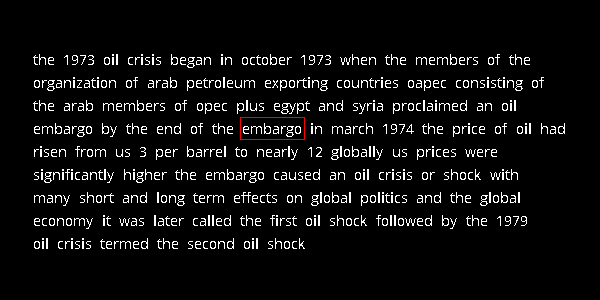

In [60]:
with open(DATA_DIR+"/v0/dev/1973_oil_crisis__8__0.json", encoding="utf8") as fp:
    dat = json.load(fp)

show_bounding_box(img, dat["embargo"][1], spread=2)

# Create image and word pairs

In [64]:
vocab = defaultdict(list) # word -> image ids

for fname in tqdm(glob(DATA_DIR + "/v0/train/*.json")):
    doc_id = os.path.split(fname)[-1]
    with open(fname, encoding="utf8") as fp:
        dat = json.load(fp)
    for word in dat:
        vocab[word].append(doc_id)


79261


In [70]:
# each word appears in how many images?
word_spread = [len(v) for v in vocab.values()]
ser = pd.Series(word_spread)
ser.describe()

count    79261.000000
mean        18.866656
std        216.077399
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      18841.000000
dtype: float64

In [86]:
# words that have highest spread
word_counts = [(k, len(v)) for k, v in vocab.items()]
word_counts = sorted(word_counts, key=lambda x: -x[1])
word_counts[:50]

[('the', 18841),
 ('of', 18193),
 ('and', 17994),
 ('in', 17289),
 ('to', 16072),
 ('a', 15276),
 ('as', 11226),
 ('by', 10179),
 ('for', 9748),
 ('with', 9585),
 ('is', 9179),
 ('was', 9006),
 ('that', 8770),
 ('s', 8385),
 ('on', 8350),
 ('from', 7877),
 ('which', 6576),
 ('it', 6147),
 ('are', 6075),
 ('an', 6068),
 ('at', 5723),
 ('or', 5616),
 ('were', 5354),
 ('be', 5057),
 ('this', 5023),
 ('also', 4824),
 ('has', 4245),
 ('not', 4214),
 ('its', 4145),
 ('have', 4127),
 ('other', 4028),
 ('their', 3945),
 ('but', 3908),
 ('one', 3728),
 ('had', 3601),
 ('such', 3524),
 ('most', 3370),
 ('first', 3289),
 ('been', 3154),
 ('more', 3120),
 ('his', 3040),
 ('some', 3031),
 ('they', 2996),
 ('all', 2951),
 ('after', 2876),
 ('new', 2819),
 ('many', 2792),
 ('during', 2749),
 ('into', 2743),
 ('who', 2631)]